In [1]:
import torch
import time
from numerical_solver import NZSolver
from train import train_nz_pinn

Using device: cpu


Solving Nakajima-Zwanzig EOM: 100%|██████████| 501/501 [00:59<00:00,  8.49it/s]


Time taken: 59.0 seconds


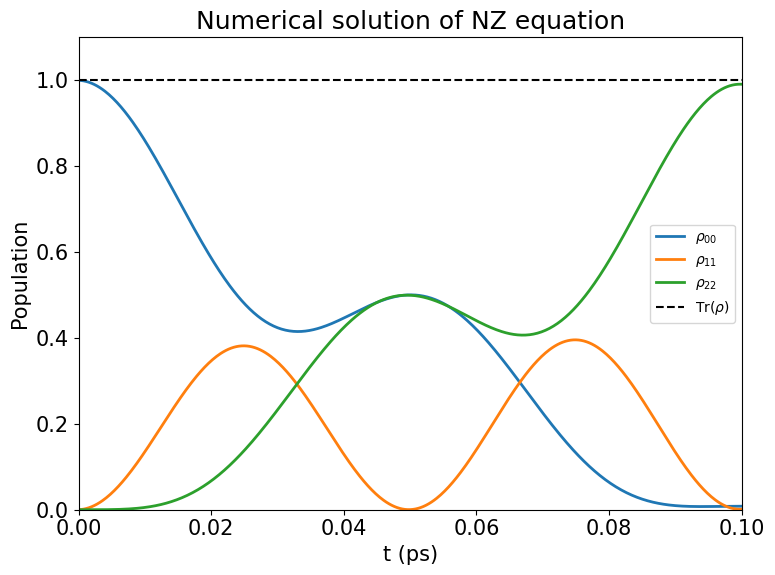

In [2]:
# Initial density matrix
rho_init = torch.diag(torch.tensor([1.0, 0.0, 0.0], dtype=torch.complex128))

solver = NZSolver(D=0.1, steps=500, A=0.0112, omega_c=3.04, T=100)

start = time.time()
times, rhos = solver.solve(rho_init)
end = time.time()
print(f"Time taken: {round(end - start, 1)} seconds")

# Plot dynamics
solver.plot_results(times, rhos)


Epoch: 0  |  Loss = 2.4599e+00


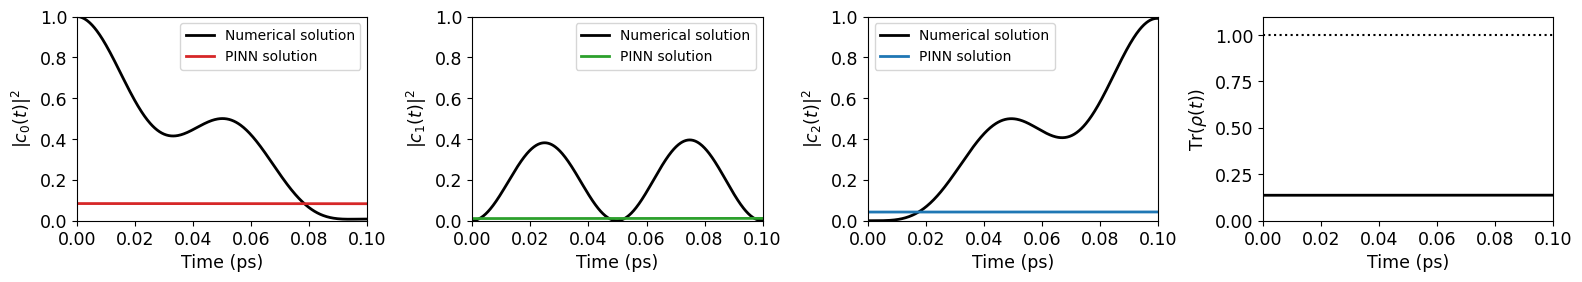

Epoch: 500  |  Loss = 1.6148e-02


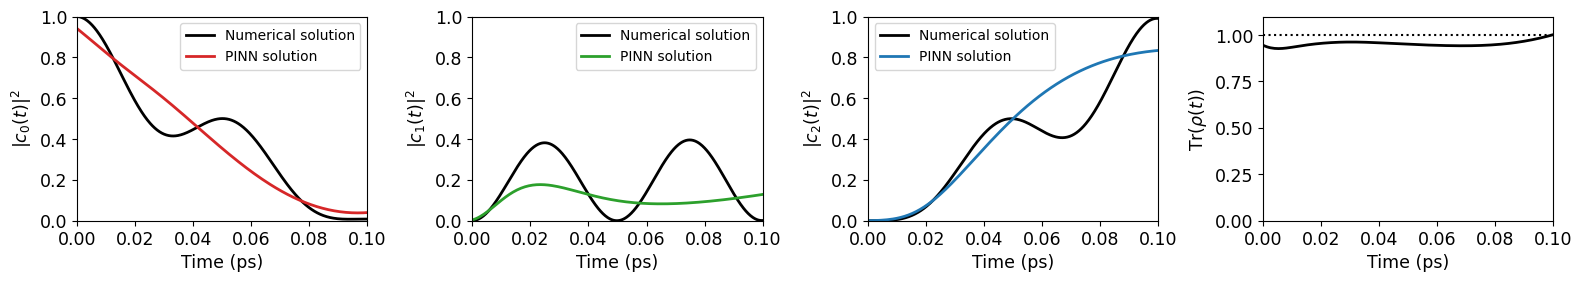

Epoch: 1000  |  Loss = 4.5612e-03


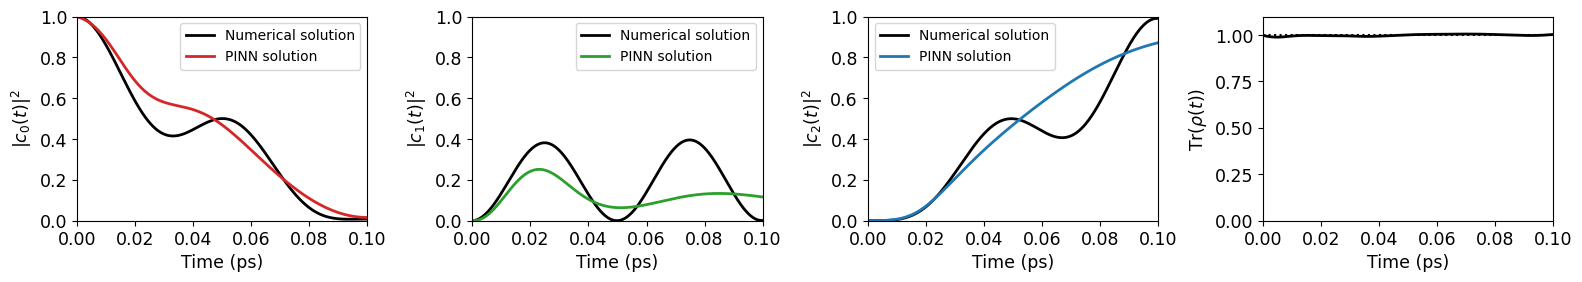

Epoch: 1500  |  Loss = 3.4780e-03


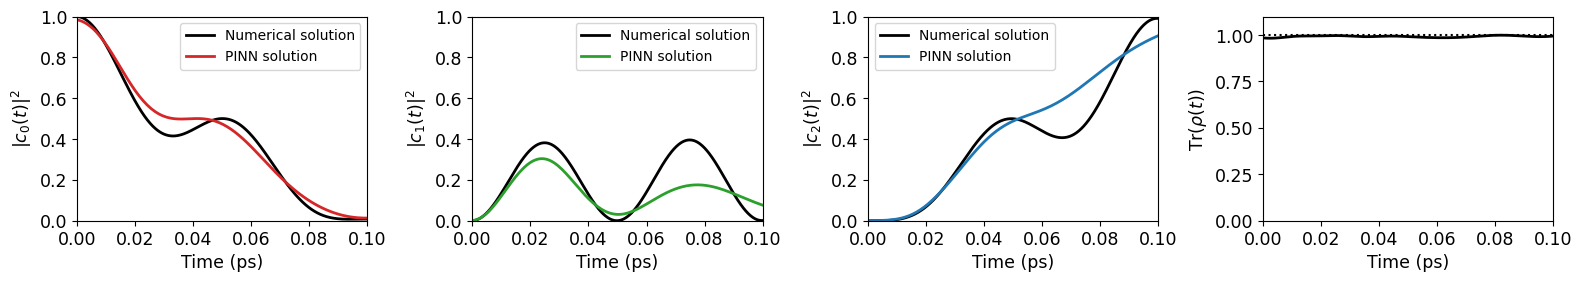

Epoch: 2000  |  Loss = 1.4877e-03


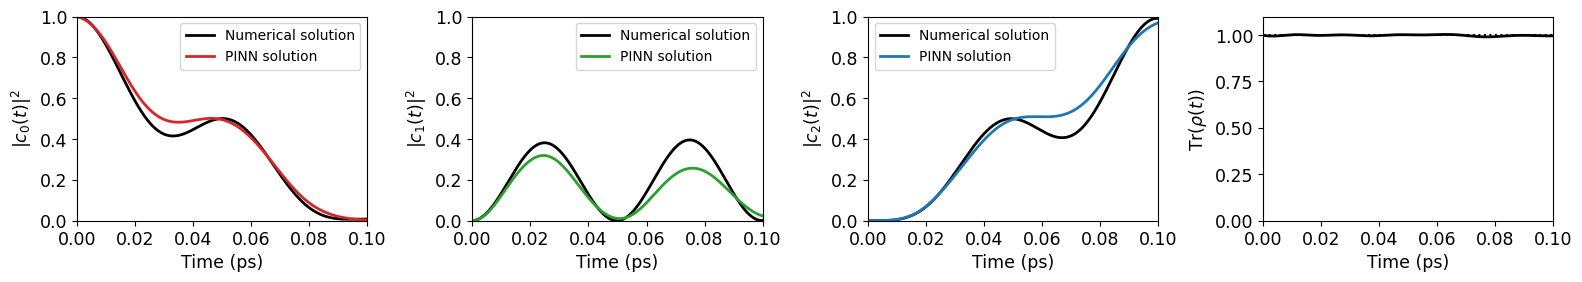

Epoch: 2500  |  Loss = 6.3231e-04


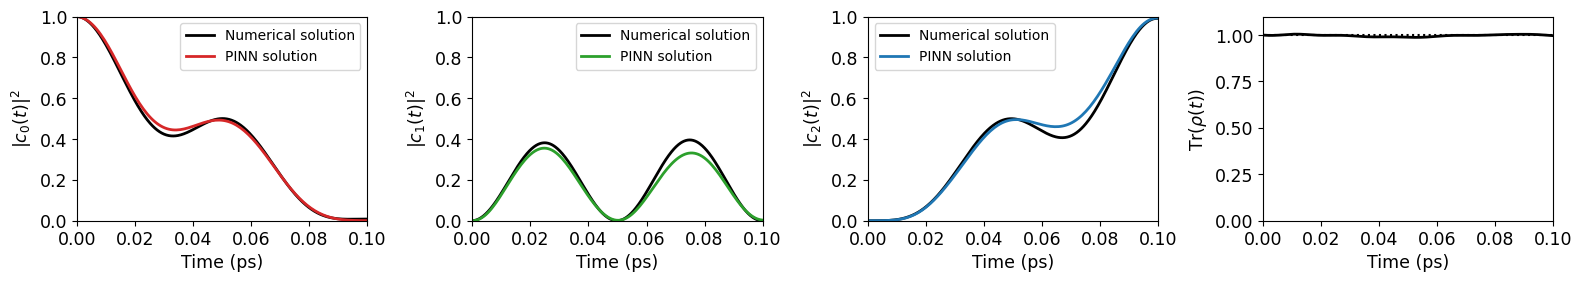

Epoch: 3000  |  Loss = 2.4733e-04


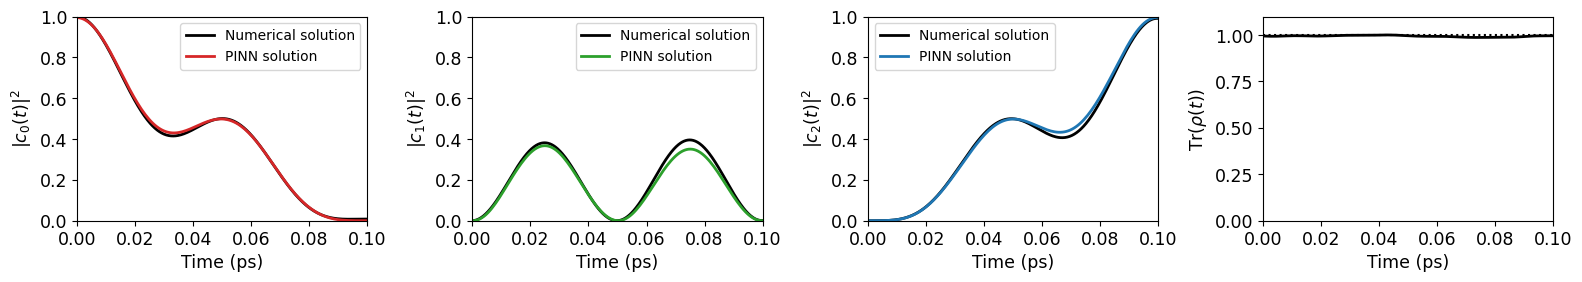

Epoch: 3500  |  Loss = 1.5385e-04


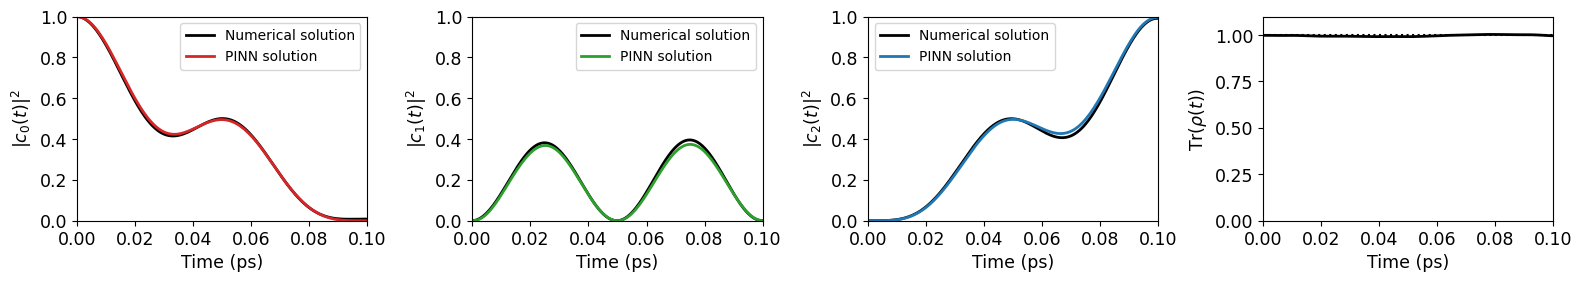

In [3]:
# Diagonalize the numerically solved density matrices
rho_diag = torch.stack([torch.real(torch.diag(rho)) for rho in rhos])

model = train_nz_pinn(times, rho_diag, D=0.1, t_intervals = 150, A=0.0112, T=100, omega_c=3.04,
                      n_layers=4, n_hidden=32, epochs=3501, lr=1e-2, plot_interval=500)

